# Projecting demographics onto population

For the population grids we have, project country-wise demographic information. For example, say we want to consider only population in a given age range, we want to apply the % of population in that age band to each population point.

## Method

- First, match countries with population points.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from rasterio import features


from numba import jit

from config import DATA_SRC, POP_DATA_SRC, HUMANS_SRC, COUNTRY_POLY_SHP

In [ ]:
API_4_DS2_en_csv_v2

HUMANS_SRC / 'education'

In [31]:
un_demographics = pd.read_csv(POP_DATA_SRC / 'UNdata_Export_20170420_163339908.csv')
un_demographics.head()

,Country or Area Code,Country or Area,Year,Area,Sex Code,Sex,Code of Age,Age,Record Type,Reliability,Source Year,Value,Value Footnotes
0,248,Åland Islands,2015.0,Total,0.0,Both Sexes,999999.0,Total,Estimate - de jure,"Final figure, complete",2016.0,28950.0,1
1,248,Åland Islands,2015.0,Total,0.0,Both Sexes,0.0,0,Estimate - de jure,"Final figure, complete",2016.0,283.0,1
2,248,Åland Islands,2015.0,Total,0.0,Both Sexes,4.0,0 - 4,Estimate - de jure,"Final figure, complete",2016.0,1510.0,1
3,248,Åland Islands,2015.0,Total,0.0,Both Sexes,1001.0,1,Estimate - de jure,"Final figure, complete",2016.0,297.0,1
4,248,Åland Islands,2015.0,Total,0.0,Both Sexes,1004.0,1 - 4,Estimate - de jure,"Final figure, complete",2016.0,1227.0,1


In [130]:
un_demographics['Country or Area Code'] = un_demographics['Country or Area Code'].apply(lambda c: c.zfill(3))

In [150]:
# Set index so we can first drop aspects we aren't interested in
un_all = un_demographics.set_index(['Sex', 'Area', 'Year', 'Country or Area Code',  'Age'])
un_all = un_all.loc['Both Sexes'].loc['Total'].loc[2015]

In [151]:
un_demographics['Country or Area Code'].unique()

array(['248', '032', '051', '533', '036', '040', '031', '112', '056',
       '060', '100', '124', '136', '152', '344', '446', '188', '191',
       '192', '531', '203', '208', '222', '233', '234', '246', '250',
       '268', '276', '300', '304', '312', '316', '831', '352', '372',
       '833', '392', '400', '417', '418', '428', '438', '462', '470',
       '480', '496', '499', '528', '554', '578', '585', '616', '620',
       '410', '498', '642', '674', '682', '688', '690', '702', '703',
       '705', '724', '729', '752', '756', '807', '780', '804', '826',
       '840', '858', '862', 'footnoteSeqID', '001', '002', '003', '004',
       '005', '006', '007', '008', '009', '010', '011', '012', '013',
       '014', '015', '016', '017', '018', '019', '020', '021', '022',
       '023', '024', '025', '026', '027', '028', '029', '030'], dtype=object)

In [152]:
un_all[un_all['Country or Area']=='Argentina']

Country or Area  Sex Code  Code of Age  \
Country or Area Code Age                                              
032                  Total         Argentina       0.0     999999.0   
                     0             Argentina       0.0          0.0   
                     0 - 4         Argentina       0.0          4.0   
                     1             Argentina       0.0       1001.0   
                     2             Argentina       0.0       2002.0   
                     3             Argentina       0.0       3003.0   
                     4             Argentina       0.0       4004.0   
                     5             Argentina       0.0       5005.0   
                     5 - 9         Argentina       0.0       5009.0   
                     6             Argentina       0.0       6006.0   
                     7             Argentina       0.0       7007.0   
                     8             Argentina       0.0       8008.0   
                     9             Argentina       0.0       9009.0   
                     10            Argentina       0.0      10010.0   
                     10 - 14       Argentina       0.0      10014.0   
                     11            Argentina       0.0      11011.0   
                     12            Argentina       0.0      12012.0   
                     13            Argentina       0.0      13013.0   
                     14            Argentina       0.0      14014.0   
                     15            Argentina       0.0      15015.0   
                     15 - 19       Argentina       0.0      15019.0   
                     16            Argentina       0.0      16016.0   
                     17            Argentina       0.0      17017.0   
                     18            Argentina       0.0      18018.0   
                     19            Argentina       0.0      19019.0   
                     20            Argentina       0.0      20020.0   
                     20 - 24       Argentina       0.0      20024.0   
                     21            Argentina       0.0      21021.0   
                     22            Argentina       0.0      22022.0   
                     23            Argentina       0.0      23023.0   
...                                      ...       ...          ...   
                     75 - 79       Argentina       0.0      75079.0   
                     76            Argentina       0.0      76076.0   
                     77            Argentina       0.0      77077.0   
                     78            Argentina       0.0      78078.0   
                     79            Argentina       0.0      79079.0   
                     80            Argentina       0.0      80080.0   
                     80 - 84       Argentina       0.0      80084.0   
                     81            Argentina       0.0      81081.0   
                     82            Argentina       0.0      82082.0   
                     83            Argentina       0.0      83083.0   
                     84            Argentina       0.0      84084.0   
                     85            Argentina       0.0      85085.0   
                     85 - 89       Argentina       0.0      85089.0   
                     86            Argentina       0.0      86086.0   
                     87            Argentina       0.0      87087.0   
                     88            Argentina       0.0      88088.0   
                     89            Argentina       0.0      89089.0   
                     90            Argentina       0.0      90090.0   
                     90 - 94       Argentina       0.0      90094.0   
                     91            Argentina       0.0      91091.0   
                     92            Argentina       0.0      92092.0   
                     93            Argentina       0.0      93093.0   
                     94            Argentina       0.0      94094.0   
                     95            Argentina       0.

# TODO need to merge on source year somehow :/

In [155]:
def sum_over_age(country_table):
    country_table = country_table.reset_index().set_index('Age')

    lower_bound = 5
    upper_bound = 99

    age_range = ['{}'.format(age) for age in range(lower_bound, upper_bound) 
                 if '{}'.format(age) in country_table.index]
    if '100+' in country_table.index:
        age_range.append('100+')
    ages = country_table.loc[age_range]
    return ages.Value.sum()
    
def fraction_over_age(country_table):
    country_table = country_table.reset_index().set_index('Age')


    lower_bound = 6
    upper_bound = 99

    age_range = ['{}'.format(age) for age in range(lower_bound, upper_bound) 
                 if '{}'.format(age) in country_table.index]

    if '100+' in country_table.index:
        age_range.append('100+')
        
    ages = country_table.loc[age_range]
    if 'Total' in country_table.index:
        total = country_table.loc['Total']['Value']
        
        return ages['Value'].sum() / total
    else:
        total_range = ['{}'.format(age) for age in range(0, 99) 
                 if '{}'.format(age) in country_table.index]
        total = country_table.loc[total_range]['Value'].sum()
        return ages['Value'].sum() / total
    
    
by_age = un_all.groupby(level='Country or Area Code', group_keys=True).apply(fraction_over_age)
by_age.name = 'frac_over_5'

In [156]:
by_age

Country or Area Code
031    0.895533
032    0.895484
036    0.922255
040    0.943169
051    0.907391
056     0.93058
060    0.920904
100    0.942912
112    0.927936
124    0.934697
136           0
152    0.895918
188           0
191    0.940948
192    0.933146
203    0.935498
208    0.936221
222    0.887592
233    0.933393
234    0.921627
246    0.933609
248     0.93696
250    0.928215
268    0.901944
276    0.948275
300    0.942805
304    0.916046
312           0
316    0.892784
344    0.930766
         ...   
499    0.926957
528     0.93623
531    0.924664
533    0.926449
554    0.913306
578    0.927326
585           0
616    0.937849
620    0.946872
642    0.940925
674    0.940453
682    0.862598
688    0.944187
690    0.902803
702    0.942622
703    0.935807
705    0.936092
724    0.940388
729    0.788412
752    0.927704
756    0.938889
780           0
804    0.933445
807    0.932217
826    0.925265
831    0.937137
833    0.923984
840    0.925188
858    0.913576
862    0.892304
Nam

In [4]:
population_file = POP_DATA_SRC / 'population_2000-2020.nc'

pop_data = xr.open_dataset(str(population_file))

In [5]:
gpd_countries = gpd.read_file(str(COUNTRY_POLY_SHP))

In [158]:
gpd_countries = gpd_countries.join(by_age, on='ISO_N3')

In [159]:
gpd_countries.plot(column='frac_over_5')

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [74]:
raster = features.rasterize(
    ((r.geometry, r.POP_EST) for _, r in gpd_countries.iterrows()),
    out_shape=pop_data.population.shape[:2]
                  )

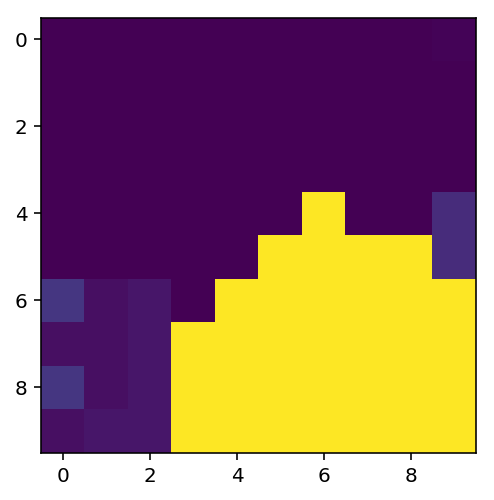

In [76]:
xplt.imshow(raster)

In [52]:
# Aborted attempt to index the population grid
# Looks like rasterising the countries shapes is going to work much better and be much faster
import rtree.index

lon, lat = np.meshgrid(pop_data.longitude[:10], pop_data.latitude[:10])

@jit
def build_index():
    idx = rtree.index.Index(str(DATA_SRC / 'lancet' / 'pop_file_index'))
    dims = lon.shape
    c = 0
    for i in range(dims[0]):
        for j in range(dims[1]):
            lo = lon[i, j]
            la = lat[i, j]
            idx.insert(c, (lo, la), obj=(i, j))
            c += 1
    return idx
    